In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import mprompt.data.data
from mprompt.data.data import TASKS_D3
import mprompt.methods.m4_evaluate as m4_evaluate
import warnings
import scipy.stats
def sem(x):
    '''Compute standard error of the mean, ignoring NaNs
    '''
    with warnings.catch_warnings():
        return scipy.stats.sem(x, ddof=0)
tqdm.pandas()
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [2]:
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename='01_explain.py')

100%|██████████| 91/91 [00:07<00:00, 12.16it/s]


In [5]:
# metadata
r['task_str'] = r.apply(lambda row: mprompt.data.data.get_task_str(row['module_name'], row['module_num']), axis=1)
r['task_keyword'] = r['task_str'].apply(lambda task_str: mprompt.data.data.get_groundtruth_keyword(task_str))
r['task_name (groundtruth)'] = r['task_str'].apply(lambda s: s.split('_')[-1])
r['ngrams_restricted'] = ~(r['module_num_restrict'] == -1)
r['num_generated_explanations'] = r['explanation_init_strs'].apply(lambda x: len(x))

# recompute recovery metrics
r['score_contains_keywords'] = r.apply(lambda row: m4_evaluate.compute_score_contains_keywords(row, row['explanation_init_strs']), axis=1)
# r['score_bert'] = r.progress_apply(lambda row: m4_evaluate.compute_score_bert(row, row['explanation_init_strs']), axis=1)

# metrics
# for met_suff in ['contains_keywords']:
for met_suff in ['contains_keywords', 'bert']:
    if 'score_' + met_suff in r.columns:
        met_val = r['score_' + met_suff]
        r['top_' + met_suff] = met_val.apply(lambda x: x[0])
        r['any_' + met_suff] = met_val.apply(lambda x: np.max(x))
        r['mean_' + met_suff] = met_val.apply(lambda x: np.mean(x))
        r[f'mean_{met_suff}_weighted'] = r[f'mean_{met_suff}'] * r['num_generated_explanations']
r['row_count_helper'] = 1

# simplifying
r = r.sort_values(by='top_score_synthetic', ascending=False).round(3)
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

In [6]:
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    d = (
        rd[[
            'task_keyword', 'top_explanation_init_strs',
            'top_contains_keywords', #        'mean_contains_keywords',
            'top_score_synthetic', 'module_num'
        ]]
        .rename(columns={
            'task_keyword': 'GT Explanation',
            'top_explanation_init_strs': 'Generated Explanation',
        })
    )
    d_ = d[d.top_contains_keywords == 0]
    slice_ = pd.IndexSlice[d_.index, d_.columns]

    # s = d.style
    display(
        d
        .style.hide()
        .set_properties(**{'background-color': '#132639'}, subset=slice_)
        .format(precision=2)
   )

GT Explanation,Generated Explanation,top_contains_keywords,top_score_synthetic,module_num
Hillary,name hillary or hillary clinton,True,0.53,17
evacuation,"concept of evacuation, or the process of leaving a place in an emergency situation",True,0.47,5
abortion,topic of abortion,True,0.40,21
pro-life,discussion of abortion and the related topics of pro-life and pro-choice,True,0.40,20
math,mathematics,True,0.35,25
politics,politics,True,0.35,53
physics,physics,True,0.33,22
Hillary,hillary or hillary clinton,True,0.32,16
atheistic,"atheism and related topics, such as theism, religious beliefs, and atheists",True,0.30,4
utility,letter u or the word utilization or utility,True,0.30,15


### Explanation recovery accuracy results

In [7]:
r = r[r['module_num'] < 40]

In [31]:
def round_3(x):
    return x.apply(lambda x: f'{x:.3f}')
def round_2(x):
    return x.apply(lambda x: f'{x:.2f}')

In [32]:
groupings = ['noise_ngram_scores', 'ngrams_restricted']
metrics = ['any_contains_keywords', 'top_contains_keywords', 'mean_contains_keywords']
metrics_weighted = ['mean_contains_keywords_weighted']
if 'score_bert' in r.columns:
    metrics += ['any_bert', 'top_bert', 'mean_bert']
    metrics_weighted += ['mean_bert_weighted']
helpers = ['row_count_helper', 'num_generated_explanations']
index_remap = {
    (0.0, False): 'Default',
    (0.0,  True): 'Restricted ngrams',
    (3.0, False): 'Noisy module',
}

g = (
    r
    .filter(groupings + metrics + metrics_weighted + helpers)
    .groupby(groupings)
    .aggregate(['sum', sem], numeric_only=True)
)
g.columns = [x[0]+'_err' if x[1] == 'sem' else x[0] for x in g.columns]

for met in metrics:
    g[met] = g[met] / g['row_count_helper']
for met in metrics_weighted:
    g[met] = g[met] / g['num_generated_explanations']

g.index = [index_remap[x] for x in g.index.values]
columns=[k for k in g.columns if not k.endswith('_err')]
for col in columns:
    err = g[col + '_err']
    if col == 'mean_contains_keywords_weighted':
        err = g['mean_contains_keywords_err']
        err *= np.sqrt(g['row_count_helper'] / g['num_generated_explanations'])
    g[col] = round_3(g[col]) + ' \\err{' + round_2(err) + '}'

g = g.drop(columns=helpers + 
           [k for k in ['mean_contains_keywords', 'mean_bert', 'any_bert', 'any_contains_keywords'] if k in g.columns])

g = g.rename(
    columns={
            'any_contains_keywords': 'Accuracy (top-5)',
            'top_contains_keywords': 'Accuracy',
            'mean_contains_keywords_weighted': 'Accuracy (no synthetic ranking)',
            'mean_contains_keywords': 'Accuracy (no synthetic, unweighted)',
            'top_bert': 'BERTScore',
            'mean_bert_weighted': 'BERTScore (no synthetic ranking)',
        }
)
cols_print = [k for k in g.columns if not k.endswith('_err')]
display(g[cols_print])
print(g[cols_print].style.to_latex(hrules=True))

,Accuracy,Accuracy (no synthetic ranking)
Default,0.850 \err{0.06},0.738 \err{0.03}
Restricted ngrams,0.769 \err{0.12},0.667 \err{0.08}
Noisy module,0.667 \err{0.10},0.452 \err{0.06}


\begin{tabular}{lll}
\toprule
 & Accuracy & Accuracy (no synthetic ranking) \\
\midrule
Default & 0.850 \err{0.06} & 0.738 \err{0.03} \\
Restricted ngrams & 0.769 \err{0.12} & 0.667 \err{0.08} \\
Noisy module & 0.667 \err{0.10} & 0.452 \err{0.06} \\
\bottomrule
\end{tabular}



### Does synthetic score help explanation recovery?

In [83]:
groupings = ['noise_ngram_scores', 'ngrams_restricted', 'top_contains_keywords']
metrics = ['top_score_synthetic']
g2 = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .pivot_table(index=['noise_ngram_scores', 'ngrams_restricted'],
                 columns='top_contains_keywords',
                 values='top_score_synthetic')
    .rename_axis(None, axis=1)  
    .rename(columns={
    True: 'Synthetic score (correct)',
    False: 'Synthetic score (incorrect)',
    })
)
g2.index = [index_remap[x] for x in g2.index.values]
display(g2)

,Synthetic score (incorrect),Synthetic score (correct)
Default,0.125,0.246
Restricted ngrams,0.110,0.222
Noisy module,0.097,0.271


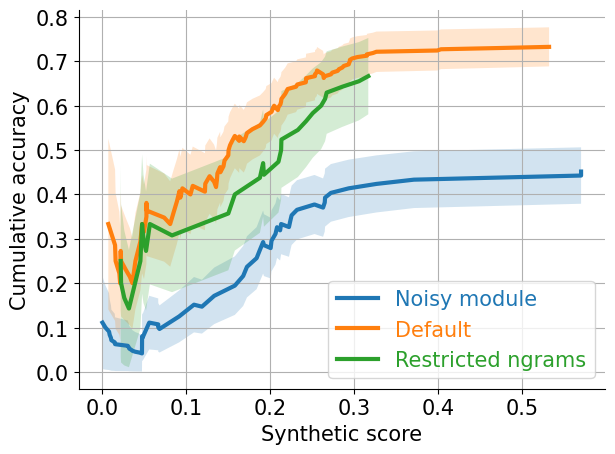

In [71]:
r['task_variation'] = r.apply(lambda row: index_remap[(row.noise_ngram_scores, row.ngrams_restricted)], axis=1)

for task_variation in r.task_variation.unique():
    d = r[r.task_variation == task_variation]


    # compute corrects
    scores_synth = sum(d.score_synthetic.values, [])
    corrects = sum(d.score_contains_keywords.values, [])
    args = np.argsort(scores_synth)
    scores_synth = np.array(scores_synth)[args]
    corrects = np.array(corrects)[args]

    # plot
    cum = np.arange(1, len(corrects) + 1)
    cumsums = np.cumsum(corrects) / cum
    sems = np.sqrt(cumsums * (1 - cumsums) / cum)

    # only plot >= 0
    args2 = scores_synth > 0
    s = scores_synth[args2]
    c = cumsums[args2]
    sems = sems[args2]

    plt.plot(s, c, '-', label=task_variation, lw=3)
    plt.fill_between(s, c - sems, c + sems, alpha=0.2, interpolate=True)
    plt.ylabel('Cumulative accuracy')
    plt.xlabel('Synthetic score')
    plt.grid()
    # plt.show()
plt.legend(labelcolor='linecolor')
# dvu.line_legend()
plt.savefig('../results/figs/synthetic_score_curves.pdf', bbox_inches='tight')
plt.show()

# Details

In [9]:
# display full strings
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )

,task_keyword,top_explanation_init_strs,top_contains_keywords,top_score_synthetic,module_num
70,Hillary,name hillary or hillary clinton,True,0.532,17
33,evacuation,"concept of evacuation, or the process of leaving a place in an emergency situation",True,0.471,5
68,abortion,topic of abortion,True,0.403,21
82,pro-life,discussion of abortion and the related topics of pro-life and pro-choice,True,0.399,20
26,politics,politics,True,0.350,53
64,physics,physics,True,0.327,22
5,Hillary,hillary or hillary clinton,True,0.322,16
58,atheistic,"atheism and related topics, such as theism, religious beliefs, and atheists",True,0.304,4
32,utility,letter u or the word utilization or utility,True,0.298,15
36,toxic,idea of danger and toxicity,True,0.295,19
